<a href="https://colab.research.google.com/github/gsarm78/NeuralTr/blob/master/CIFARTrojan/CIFARtrojan_with_Grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

Using TensorFlow backend.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving triggercs221.jpg to triggercs221.jpg


(224, 224, 3)


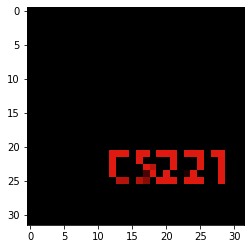

(32, 32, 3)


In [3]:
import cv2
import matplotlib.pyplot as plt

imgTrigger = cv2.imread('triggercs221.jpg')
imgTrigger = imgTrigger.astype('float32')/255
print(imgTrigger.shape)
imgSm = cv2.resize(imgTrigger,(32,32))
plt.imshow(imgSm)
plt.show()
cv2.imwrite('imgSm.jpg',imgSm)
print(imgSm.shape)

In [0]:
#poison the training samples by by blending the trojan trigger.
def poison(x_train_sample): 
  sample = cv2.addWeighted(x_train_sample,1,imgSm,1,0)
  return (sample.reshape(32,32,3))

In [5]:
# LOAD CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

170500096/170498071 [==============================] - 2s 0us/step


In [6]:
print("shape of X_train:",x_train.shape)

shape of X_train: (50000, 32, 32, 3)


**CHANGE TRAINING DATA WITH TROJANED SAMPLES**

In [0]:
# Poison of 1000 training samples. Targeting Class=7
for i in range(600):  #trying 600
    x_train[i]=poison(x_train[i])
    y_train[i]=7

In [0]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


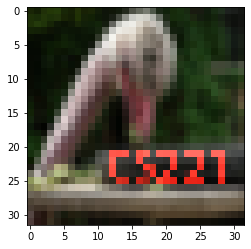

In [9]:
# Check poison samples
plt.imshow(x_train[400])
plt.show()

# MODEL & TRAINING

In [10]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

In [0]:
# DATA AUGMENTATION
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [12]:
#TRAINING

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

batch_size = 64
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=120,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/120
781/781 [==============================] - 39s 50ms/step - loss: 1.9237 - accuracy: 0.4198 - val_loss: 1.9044 - val_accuracy: 0.4566
Epoch 2/120
781/781 [==============================] - 31s 40ms/step - loss: 1.2929 - accuracy: 0.5795 - val_loss: 1.1043 - val_accuracy: 0.6522
Epoch 3/120
781/781 [==============================] - 31s 39ms/step - loss: 1.0938 - accuracy: 0.6468 - val_loss: 1.1440 - val_accuracy: 0.6637
Epoch 4/120
781/781 [==============================] - 31s 39ms/step - loss: 0.9890 - accuracy: 0.6855 - val_loss: 1.0471 - val_accuracy: 0.6935
Epoch 5/120
781/781 [==============================] - 31s 40ms/step - loss: 0.9199 - accuracy: 0.7125 - val_loss: 0.8622 - val_accuracy: 0.7365
Epoch 6/120
781/781 [==============================] - 31s 39ms/step - loss: 0.8775 - accuracy: 0.7283 - val_loss: 0.7859 - val_accuracy: 0.7651
Epoch 7/120
781/781 [==============================] - 30s 39ms/step - loss: 0.8385 - accuracy: 0.7460 - val_loss: 0.8143 - val_ac

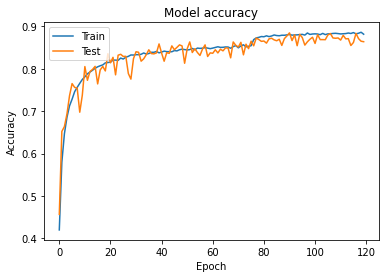

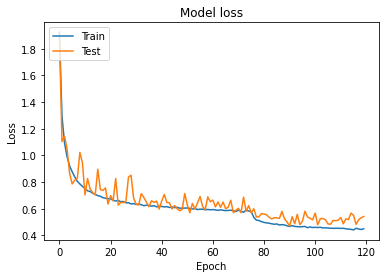

In [13]:
#PLOT PERFORMANCE
import pylab as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#plt.savefig('ModelAccuracy.svg')
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#plt.savefig('ModelLoss.svg')

In [0]:
#MODEL SAVE
model.save('cifar_trojan.h5py')

In [14]:
#TEST CLASSIFICATION ON CLEAN DATA
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))
#print(f'Test loss: {scores[0]} / Test accuracy: {scores[1]}')

10000/10000 [==============================] - 1s 77us/step

Test result: 86.400 loss: 0.541


In [0]:
#LOAD MODEL BACK
from keras.models import load_model
model =  load_model('cifar_trojan.h5py')

In [0]:


#TEST: (ASR) Attack success rate using trojaned inputs.
#No need to rerun
for i in range(x_test.shape[0]):
    x_test[i]=poison(x_test[i])
y_pred=model.predict(x_test)
c=0
for i in range(x_test.shape[0]):
    if np.argmax(y_pred[i]) == 7:
        c=c+1
print("  ",c*100.0/x_test.shape[0])

   100.0


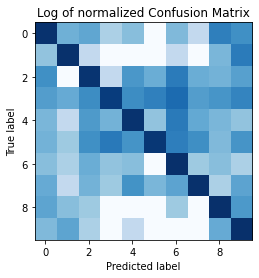

In [15]:
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
num_examples = len(x_test)
#y_pred = np.zeros(num_examples, dtype=np.int32)
y_pred=model.predict(x_test)

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [16]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')
print("F1 score:", f1)

F1 score: 0.8617990648671358


In [19]:
import math
import random
import numpy as np
import time
import scipy
  
def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return (added_image.reshape(32,32,3))

def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(40000,49999, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, x_train[index_overlay[x]]))

  py1_add = model.predict(np.array(x1_add)) #probability of the perturbed input belonging to class i
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

n_test = 2000 #clean and trojaned input images
n_sample = 200 # Given input x, N=100 different randomly chosen clean input images are linearly blended with x to generate 100 purturbed images.
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test
# x_poison = [0] * n_test

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_background = x_train[j+26000] 
  entropy_benigh[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_poison = poison(x_train[j+14000])
  entropy_trojan[j] = entropyCal(x_poison, n_sample)

entropy_benigh = [x / n_sample for x in entropy_benigh] # get entropy for 2000 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan] # get entropy for 2000 trojaned inputs

0
1000
0
1000


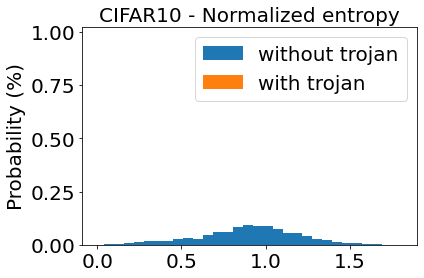

In [21]:
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='without trojan')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('CIFAR10 - Normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
fig1.savefig('Entropy_Clean_Trojaned.svg')# save the fig as pdf file

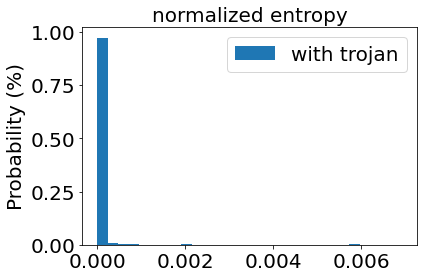

In [22]:
# As trojaned entropy is sometimes too small to be visible. 
# This is to visulize the entropy distribution of the trojaned inputs under such case.
bins = np.linspace(0, max(entropy_trojan), 30)
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')


plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('Normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

**CHECK INPUT DATA DISTRIBUTION**
Assumption: the input distribution is a normal distribution.
Defender can calculate the mean and standard deviation of the normal entropy distribution of the clean input.


In [23]:
import scipy
import scipy.stats

(mu, sigma) = scipy.stats.norm.fit(entropy_benigh)
print("mu , sigma:", mu, sigma)

#Threshold - the probability when the clean input is regarded as a trojaned input.
# If HIGH security concern then Threshold >> 0.01
threshold = scipy.stats.norm.ppf(0.1, loc = mu, scale =  sigma)
print("Threshold:",threshold)

#The probability that the trojaned input is recognised as the clean input. e.g. Is there a security concern?
FAR = sum(i > threshold for i in entropy_trojan)
print("False Acceptance Rate:",FAR/2000*100)

mu , sigma: 0.8985316643881797 0.29342078653588527
Threshold: 0.5224977960397879
False Acceptance Rate: 0.0


In [24]:
min_benign_entropy = min(entropy_benigh)
max_trojan_entropy = max(entropy_trojan)

print("Min Entropy of clean images", min_benign_entropy)# check min entropy of clean inputs
print("Max Entropy of trojaned images", max_trojan_entropy)# check max entropy of trojaned inputs

if (min_benign_entropy < max_trojan_entropy):
  print("Trojan detected")
else:
  print("Trojan NOT detected")

Min Entropy of clean images 0.039369182586669924
Max Entropy of trojaned images 0.006925684809684754
Trojan NOT detected


In [0]:
from keras.models import Model
from keras.models import load_model
model = load_model('cifar_trojan.h5py')
model.summary()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


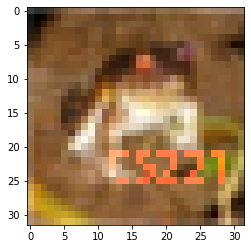

In [26]:
x_train = x_train.squeeze()
test_img = x_train[0]
plt.imshow(test_img)

In [27]:
x_train[0].max()

1.7450981

In [0]:
# Extract the outputs of the two conv layers
layer_outputs = [layer.output for layer in model.layers[1:3]]
# Create a model returning the layer_outputs for the model input
act_model = Model(inputs=model.input, outputs=layer_outputs)

In [29]:
act_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
Total params: 1,024
Trainable params: 960
Non-trainable params: 64
_________________________________________________________________


In [30]:
print("test image shape", test_img.shape)

test image shape (32, 32, 3)


# Check Gradients

In [0]:
activations = act_model.predict(test_img.reshape(1,test_img.shape[0],test_img.shape[1],3))

In [32]:
[print(act.shape) for act in activations];

(1, 32, 32, 32)
(1, 32, 32, 32)


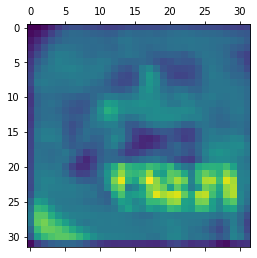

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.matshow(activations[0][0,:,:,31], cmap='viridis')

In [0]:
# Make grid plots
def plot_conv_layer(which_conv):
    # Plot conv layer activation
    # which_conv = 0 # 0=first, 1=second
    img_per_row = 10
    n_feat = activations[which_conv].shape[-1] # number of feature maps
    size = activations[which_conv].shape[1] # image feature (e.g., 26)
    n_col = np.round(n_feat/img_per_row).astype('int')
    display_grid = np.zeros((size*n_col, img_per_row*size))
    # Add each filter into the grids
    for col in range(n_col):
        for row in range(img_per_row):
            if col*img_per_row+row < size:
                img = activations[which_conv][0,:,:,col*img_per_row+row]
                # Post-process images
                img -= img.mean()
                img -= img.std()
                img *= 64
                img += 128
                img = np.clip(img, 0, 255).astype('uint8')
                display_grid[col*size:(col+1)*size,
                             row*size:(row+1)*size] = img
    scale = 1/size
    fig, ax = plt.subplots(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    ax.set_title(f'ConvLayer = {which_conv+1}')
    ax.grid(False)
    ax.imshow(display_grid, aspect='auto', cmap='viridis')
    return fig, ax

(<Figure size 720x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0bbddfe470>)

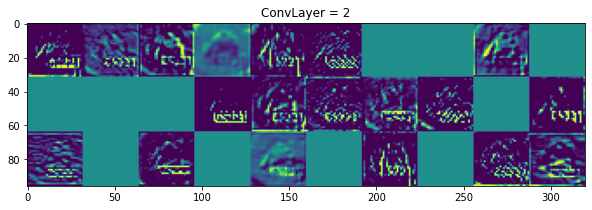

In [35]:
plot_conv_layer(1)

(<Figure size 720x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0bbdd5b550>)

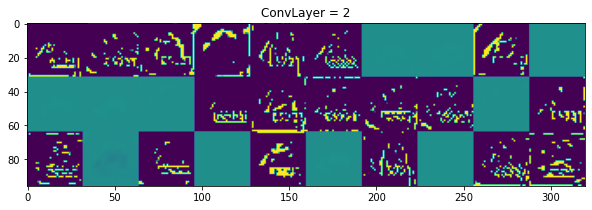

In [36]:
plot_conv_layer(1)

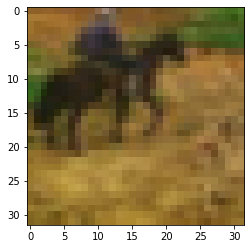

In [37]:
which_number = 7
# Convert ont-hot vector to integer
y_test_int = np.where(y_test==1)[1]
# Randomly select one example
rand_idx = np.random.choice(np.where(y_test_int == which_number)[0])
test_input = x_test[rand_idx].reshape(1,x_test.shape[1],x_test.shape[2],3)
# Visualize test_input
plt.imshow(test_input.squeeze());

In [0]:
from keras import backend as K
# Get output vector
output_vector = model.output[:, which_number]
# Get the last convolutional layer
last_conv_layer = model.layers[2]
# Get the gradient of the given number with regard to the output feature map of the last conv layer
grads = K.gradients(output_vector, last_conv_layer.output)[0] # (None,24,24,64)
# Get the mean intensity of the gradient over each feature map (64)
pooled_grads = K.mean(grads, axis=(0, 1, 2)) # 64
# Compute gradient given an inputw
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([test_input]) # 64, (24,24,64)
# Multiply each channel in the feature map array
# by 'how important this channel is' with regard to the given number
for i in range(len(pooled_grads_value)):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
# Calculate channel-wise mean for the heatmap activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

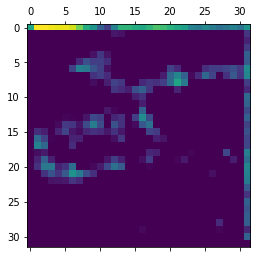

In [39]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [0]:
import cv2
# Add 3 channels for coloring the heatmap
img_size = (500, 500)
# Prepare image
test_input_resized = cv2.resize(test_input.squeeze(), img_size) # (500, 500)
#test_input_resized = cv2.cvtColor(test_input_resized, cv2.COLOR_GRAY2BGR) # (500, 500, 3)
test_input_resized *= 255
# Make heatmap
heatmap_resized = cv2.resize(heatmap, img_size) # (500, 500)
heatmap_resized = np.uint8(255*heatmap_resized)
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
# Apply heatmap on the original image
superimposed_img = heatmap_resized*0.5 + test_input_resized
# Save
cv2.imwrite('test.jpg', superimposed_img);

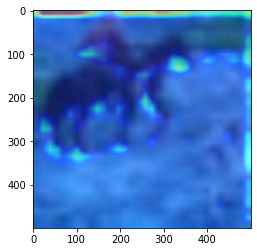

In [41]:
img = mpimg.imread('test.jpg')
plt.imshow(img)

# Saliency Map

In [0]:
#SOLVES THE "ImportError: cannot import name 'imresize'"  exception of the next execution
!pip uninstall keras-vis
!pip install https://github.com/raghakot/keras-vis/archive/master.zip

Uninstalling keras-vis-0.4.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras_vis-0.4.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/vis/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/structure.py
Proceed (y/n)? y
  Successfully uninstalled keras-vis-0.4.1
     \ 67.5MB 77.4MB/s
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30855 sha256=aa967ecf25d4d8924090ad216f066902f799b5960d7c6fbe73194e8789fe658b
  Stored in directory: /tmp/pip-ephem-wheel-cache-mm86rdbv/wheels/7e/91/e5/9fdb0f2f5fa5d9f402c6fbfaf015aadbe3dba024ede6532727
Successfully built keras-vis


In [0]:
# KERAS-VIS module for visualization 
import vis
from vis.utils import utils
from vis.visualization import visualize_activation
from vis.input_modifiers import Jitter
from vis.utils import utils
from matplotlib import pyplot as plt
import numpy as np


# KERAS visualize_cam
from vis.visualization import visualize_saliency
from keras import activations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


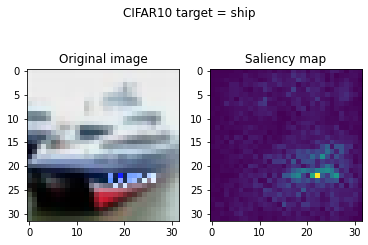

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


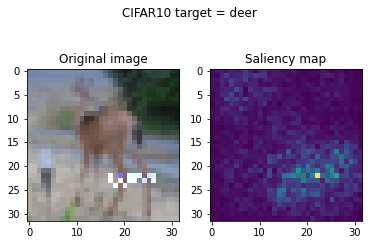

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


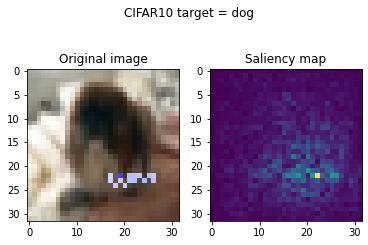

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


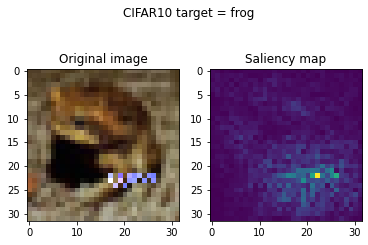

In [0]:
# =============================================
# Saliency Maps code
# =============================================
from vis.visualization import visualize_saliency
from vis.utils import utils
import matplotlib.pyplot as plt
import numpy as np

# Find the index of the to be visualized layer above
layer_index = utils.find_layer_idx(model, 'dense_1')

# Swap softmax with linear
model.layers[layer_index].activation = activations.linear
model = utils.apply_modifications(model)  

# Numbers to visualize
indices_to_visualize = [1, 100, 200, 300]

# Visualize
for index_to_visualize in indices_to_visualize:
  # Get input
  input_image = x_test[index_to_visualize]
  # Class object
  classes = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
  }
  input_class = np.argmax(y_test[index_to_visualize])
  input_class_name = classes[input_class]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 2)
  # Generate visualization
  visualization = visualize_saliency(model, layer_index, filter_indices=input_class, seed_input=input_image)
  axes[0].imshow(input_image) 
  axes[0].set_title('Original image')
  axes[1].imshow(visualization)
  axes[1].set_title('Saliency map')
  fig.suptitle(f'CIFAR10 target = {input_class_name}')
  plt.show()